<a href="https://colab.research.google.com/github/nid-22/semantic-search-with-rag/blob/main/Fashion_search_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔍 Retrieval-Augmented Generation (RAG) Project

This project implements a **three-layer RAG architecture** to build an effective and explainable search system over a Kaggle dataset. The layers include:

1. **Embedding Layer**  
2. **Search Layer**  
3. **Generation Layer**

---

## 📘 1️⃣ Embedding Layer

This layer is responsible for preprocessing the PDF, chunking the content, and embedding it into a vector space for semantic search.

### ✅ Steps:
- **Chunk** the content: (skipped for this project)
  - Fixed-size chunks
  - Sentence-based or paragraph-based chunking
- **Embed** the chunks using:
  - `OpenAIEmbedding` model *(via OpenAI API)*
  - Or any model from **SentenceTransformers** (e.g., `all-MiniLM-L6-v2`, `multi-qa-MiniLM`, etc.)
- **Store** the embeddings in a **ChromaDB** vector database for fast retrieval.

---

##  2️⃣ Search Layer

This layer handles the semantic search using user queries and reranks the results for improved relevance.

### ✅ Steps:
- Design at least **3 queries** based on the document
- **Embed** the queries using the same embedding model.
- **Search ChromaDB** to retrieve top-N relevant chunks.
- Implement a **caching mechanism** to avoid reprocessing repeated queries.
- Apply a **Cross-Encoder Re-ranker** (e.g. `cross-encoder/ms-marco-MiniLM-L-6-v2`) from HuggingFace to re-score and reorder the retrieved chunks.

---

##  3️⃣ Generation Layer

This layer generates the final answer by feeding the top reranked chunks into a powerful LLM.

### ✅ Steps:
- Construct a **detailed prompt** that includes:
  - The user query
  - The top-3 reranked chunks as context
  - Clear instructions on how to answer
- Use **OpenAI GPT-4**, **GPT-3.5**, or any open-source instruction-tuned LLM to generate the final response. I have used Open source Huggingface model
- Optionally include **few-shot examples** to improve generation quality.

###  Required Outputs:
- **Final answer generated** by the LLM  for each query

---

## ✅ Summary :
- 📄 Chunked and embedded document (stored in ChromaDB)
- 🔍 Query → Top-N results → Re-ranked results
- 🧾 Prompt → Answer from LLM

---

## 💡 Bonus Tips:
- Compare performance across:
  - Different chunk sizes
  - Different embedding models
  - Different re-ranking strategies
- Keep your code modular so you can plug-and-play different components.

---


In [2]:
!pip install pdfplumber tiktoken openai chromaDB sentence-transformers -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 7.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.9 MB/s eta 0:00:00

In [3]:
# Importing necessary libraries
import tiktoken  # Assuming this is a custom library for tokenization
import openai  # OpenAI library for accessing GPT models
import chromadb  # ChromaDB library for database operations
from pathlib import Path  # For handling file paths
import pandas as pd  # Pandas for data manipulation
from operator import itemgetter  # For sorting dictionaries
import json  # For working with JSON data
from sklearn.feature_extraction.text import TfidfVectorizer  # TF-IDF vectorizer
from sklearn.metrics.pairwise import cosine_similarity  # Cosine similarity calculation
from nltk.corpus import stopwords  # Stopwords for text processing
from nltk.tokenize import word_tokenize  # Tokenization
import string  # String manipulation functions
from PIL import Image  # Image processing library
import requests  # For making HTTP requests
from io import BytesIO  # For handling binary data
import matplotlib.pyplot as plt  # Matplotlib for visualization
from matplotlib import table  # Table visualization in Matplotlib
import os  # Operating system utilities
import matplotlib.image as mpimg
from sentence_transformers import SentenceTransformer

# Import the CrossEncoder library from sentence_transformers
from sentence_transformers import CrossEncoder, util
# Importing required functions and classes from ChromaDB
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [4]:

from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [5]:
file_path = '/content/drive/MyDrive/Colab Notebooks/fashion search AI/Fashion Dataset v2.csv'

fashion_data = pd.read_csv(file_path)

fashion_data.head()

,p_id,name,products,price,colour,brand,img,ratingCount,avg_rating,description,p_attributes
0,17048614,Khushal K Women Black Ethnic Motifs Printed Ku...,"Kurta, Palazzos, Dupatta",5099.0,Black,Khushal K,http://assets.myntassets.com/assets/images/170...,4522.0,4.418399,Black printed Kurta with Palazzos with dupatta...,"{'Add-Ons': 'NA', 'Body Shape ID': '443,333,32..."
1,16524740,InWeave Women Orange Solid Kurta with Palazzos...,"Kurta, Palazzos, Floral Print Dupatta",5899.0,Orange,InWeave,http://assets.myntassets.com/assets/images/165...,1081.0,4.119334,Orange solid Kurta with Palazzos with dupatta<...,"{'Add-Ons': 'NA', 'Body Shape ID': '443,333,32..."
2,16331376,Anubhutee Women Navy Blue Ethnic Motifs Embroi...,"Kurta, Trousers, Dupatta",4899.0,Navy Blue,Anubhutee,http://assets.myntassets.com/assets/images/163...,1752.0,4.161530,Navy blue embroidered Kurta with Trousers with...,"{'Add-Ons': 'NA', 'Body Shape ID': '333,424', ..."
3,14709966,Nayo Women Red Floral Printed Kurta With Trous...,"Kurta, Trouser, Dupatta",3699.0,Red,Nayo,http://assets.myntassets.com/assets/images/147...,4113.0,4.088986,Red printed kurta with trouser and dupatta<br>...,"{'Add-Ons': 'NA', 'Body Shape ID': '333,424', ..."
4,11056154,AHIKA Women Black & Green Printed Straight Kurta,Kurta,1350.0,Black,AHIKA,http://assets.myntassets.com/assets/images/110...,21274.0,3.978377,"Black and green printed straight kurta, has a ...","{'Body Shape ID': '424', 'Body or Garment Size..."


In [6]:
images_folder_path = '/content/drive/MyDrive/Colab Notebooks/fashion search AI/images'


In [7]:
print(fashion_data.columns)

Index(['p_id', 'name', 'products', 'price', 'colour', 'brand', 'img',
       'ratingCount', 'avg_rating', 'description', 'p_attributes'],
      dtype='object')


In [8]:
fashion_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14214 entries, 0 to 14213
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   p_id          14214 non-null  int64  
 1   name          14214 non-null  object 
 2   products      14214 non-null  object 
 3   price         14214 non-null  float64
 4   colour        14214 non-null  object 
 5   brand         14214 non-null  object 
 6   img           14214 non-null  object 
 7   ratingCount   6530 non-null   float64
 8   avg_rating    6530 non-null   float64
 9   description   14214 non-null  object 
 10  p_attributes  14214 non-null  object 
dtypes: float64(3), int64(1), object(7)
memory usage: 1.2+ MB


## 1. Generate Embeddings using SentenceTransformer and ChromaDB

In [10]:
# Define the path for storing ChromaDB collections
chroma_data_path = '/content/drive/MyDrive/Colab Notebooks/fashion search AI/ChromaDB_Data'
client = chromadb.PersistentClient(path=chroma_data_path)

In [11]:
# setting up  mebedding model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [12]:
# make the dataframe in a dictionary format for embedding
fashion_data['metadata'] = fashion_data.apply(lambda x: x.to_dict(), axis=1)

In [13]:
fashion_data['metadata'][0]

{'p_id': 17048614,
 'name': 'Khushal K Women Black Ethnic Motifs Printed Kurta with Palazzos & With Dupatta',
 'products': 'Kurta, Palazzos, Dupatta',
 'price': 5099.0,
 'colour': 'Black',
 'brand': 'Khushal K',
 'img': 'http://assets.myntassets.com/assets/images/17048614/2022/2/4/b0eb9426-adf2-4802-a6b3-5dbacbc5f2511643971561167KhushalKWomenBlackEthnicMotifsAngrakhaBeadsandStonesKurtawit7.jpg',
 'ratingCount': 4522.0,
 'avg_rating': 4.4183989385227775,
 'description': "Black printed Kurta with Palazzos with dupatta <br> <br> <b> Kurta design:  </b> <ul> <li> Ethnic motifs printed </li> <li> Anarkali shape </li> <li> Regular style </li> <li> Mandarin collar,  three-quarter regular sleeves </li> <li> Calf length with flared hem </li> <li> Viscose rayon machine weave fabric </li> </ul> <br> <b> Palazzos design:  </b> <ul> <li> Printed Palazzos </li> <li> Elasticated waistband </li> <li> Slip-on closure </li> </ul>Dupatta Length 2.43 meters Width:&nbsp;88 cm<br>The model (height 5'8) is w

In [14]:
# extract the text from metadata to create embedding
def combine_text(metadata):
    """
    combines 'name' and 'description' from the metadata dictionary.
    Returns a fallback string if both fields are missing or empty.
    """
    name = metadata.get("name", "").strip()
    desc = metadata.get("description", "").strip()

    # If both fields are empty, return a fallback
    if not name and not desc:
        return "No description available."

    return (name + " " + desc).strip()

# Apply the function to each row's metadata and convert to list
text_data = fashion_data["metadata"].apply(combine_text).to_list()

In [15]:
from chromadb.api.types import EmbeddingFunction, Embeddings, Documents

class HuggingFaceEmbeddingFunction(EmbeddingFunction):
    def __init__(self, model: SentenceTransformer):
        self.model = model

    def __call__(self, input):
        """
        input: A list of text strings (Chroma calls it 'input').
        Must return a list of lists (float vectors).
        """
        embeddings = self.model.encode(input, show_progress_bar=False)
        return embeddings.tolist()


model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Create an instance of your embedding function
huggingface_embedding_function = HuggingFaceEmbeddingFunction(model)

# Create or load the Chroma collection
fashion_collection = client.get_or_create_collection(
    name="fashion_collection",
    embedding_function=huggingface_embedding_function)


for idx, data in enumerate(fashion_data["metadata"]):
    fashion_collection.add(
        documents=[text_data[idx]],
        metadatas=[data],
        ids=[str(data['p_id'])]
    )

Streaming output truncated to the last 5000 lines.


In [16]:
fashion_collection.peek(5)

{'ids': ['17048614', '16524740', '16331376', '14709966', '11056154'],
 'embeddings': array([[-0.0784939 ,  0.10212599, -0.01944741, ..., -0.12070954,
          0.00279512,  0.0516241 ],
        [-0.05209494,  0.04772704,  0.00736133, ..., -0.05820062,
          0.06937458,  0.00777674],
        [-0.06548386,  0.04187374,  0.04088256, ..., -0.06983769,
         -0.00160561,  0.0158866 ],
        [-0.0553856 ,  0.04102006, -0.00424994, ..., -0.1018132 ,
          0.04594184,  0.03690313],
        [-0.04694391,  0.08671565, -0.01625874, ..., -0.11866883,
          0.0352777 ,  0.06115273]]),
 'documents': ["Khushal K Women Black Ethnic Motifs Printed Kurta with Palazzos & With Dupatta Black printed Kurta with Palazzos with dupatta <br> <br> <b> Kurta design:  </b> <ul> <li> Ethnic motifs printed </li> <li> Anarkali shape </li> <li> Regular style </li> <li> Mandarin collar,  three-quarter regular sleeves </li> <li> Calf length with flared hem </li> <li> Viscose rayon machine weave fabric <

In [55]:
 #Prompt the user to enter a fashion-related query with specific requirements
query = input("Please enter your fashion-related query. For example, you can mention the color, size, price range, style, and any specific patterns or designs you prefer: ")

#“Looking for a cozy beige cardigan under ₹2000, good for chilly evenings.”
#“I want bright yellow sneakers, lightweight and comfy. No strict budget.”
#“Any floral palazzo pants in size M, preferably under ₹1500?”
#“Need a navy or gray blazer-trouser set, slim-fit, ~₹3000–₹5000.”
#“Searching for a mint-green cotton skirt-top combo. No budget limit.”

Please enter your fashion-related query. For example, you can mention the color, size, price range, style, and any specific patterns or designs you prefer: I want bright yellow sneakers, lightweight and comfy. No strict budget.


In [56]:
results = fashion_collection.query(
    query_texts=query,  # User query provided as input
    n_results=5  # Number of results to retrieve, in this case, the top 3 most relevant results
)

In [58]:
images_folder_path

'/content/drive/MyDrive/Colab Notebooks/fashion search AI/images'

In [59]:
image_path = os.path.join(images_folder_path, str(16928316) + '.jpg')

Applying a Cross-Encoder Re-ranker

In [60]:
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [61]:
docs = results["documents"][0]
ids = results["ids"][0]
metas = results["metadatas"][0]
distances = results["distances"][0]
retrieved_docs = results["documents"][0]

query_doc_pairs = [(query, doc) for doc in retrieved_docs]
cross_rerank_scores = cross_encoder.predict(query_doc_pairs)
results_df = pd.DataFrame({
    'IDs': ids,
    'Documents': docs,
    'Distances': distances,
    'Metadatas': metas,
    'Reranked_scores': cross_rerank_scores
})



In [62]:
results_df = results_df.sort_values(by="Reranked_scores", ascending=False)


In [63]:
results_df

,IDs,Documents,Distances,Metadatas,Reranked_scores
2,17108570,DressBerry Women Bright Yellow Solid Wide Leg ...,1.093944,"{'brand': 'DressBerry', 'colour': 'Yellow', 'd...",-3.220710
0,18962114,Nike Women Purple Loose Fit High Rise FLY CROS...,1.039340,"{'brand': 'Nike', 'colour': 'Purple', 'descrip...",-9.850366
1,19039214,Purple State Orange Solid Basic Jumpsuit with ...,1.079861,"{'brand': 'Purple State', 'colour': 'Orange', ...",-11.144885
3,15634238,URBANIC Navy Blue Pure Cotton Solid Basic Jump...,1.097615,"{'avg_rating': 2.857142857142857, 'brand': 'UR...",-11.281588
4,15851958,URBANIC Navy Blue & Brown Off-Shoulder Printed...,1.100223,"{'brand': 'URBANIC', 'colour': 'Navy Blue', 'd...",-11.350392


**Generation Layer**

In [64]:
from huggingface_hub import login
login()

In [65]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch

model_name = "mistralai/Mistral-7B-Instruct-v0.1"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

rag_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    do_sample=False
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


In [71]:
query

'I want bright yellow sneakers, lightweight and comfy. No strict budget.'

In [ ]:
top_k = 5
top_results_df = results_df.head(top_k)

context = "\n\n".join(top_results_df["Documents"].tolist())

prompt = f"""You are an intelligent assistant capable of searching a plethora of product descriptions to find and recommend appropriate choices against a user query.

You are given 3 product descriptions below. Show the most relevant ones to the user, it can be more than 1.

Context:
{context}

Question:
{query}

Answer:"""

response = rag_pipeline(prompt)[0]["generated_text"]

# Clean the output
print("🔎 Generated Answer:\n")
print(response.split("Answer:")[-1].strip())


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [68]:
import matplotlib.pyplot as plt
import os
from PIL import Image

def display_top_results_with_images(results_df, images_folder_path, top_k=3):
    top_results = results_df.head(top_k)

    fig, axes = plt.subplots(1, top_k, figsize=(5 * top_k, 6))
    if top_k == 1:
        axes = [axes]  # Ensure it's iterable

    for i, (_, row) in enumerate(top_results.iterrows()):
        item_id = row["IDs"]
        image_path = os.path.join(images_folder_path, str(item_id) + ".jpg")

        if os.path.exists(image_path):
            img = Image.open(image_path)
            axes[i].imshow(img)
            axes[i].axis("off")
            title = row["Metadatas"].get("productDisplayName", f"ID: {item_id}")
            axes[i].set_title(title, fontsize=10)
        else:
            axes[i].axis("off")
            axes[i].text(0.5, 0.5, f"Image not found\nID: {item_id}", fontsize=10, ha='center', va='center')

    plt.tight_layout()
    plt.show()


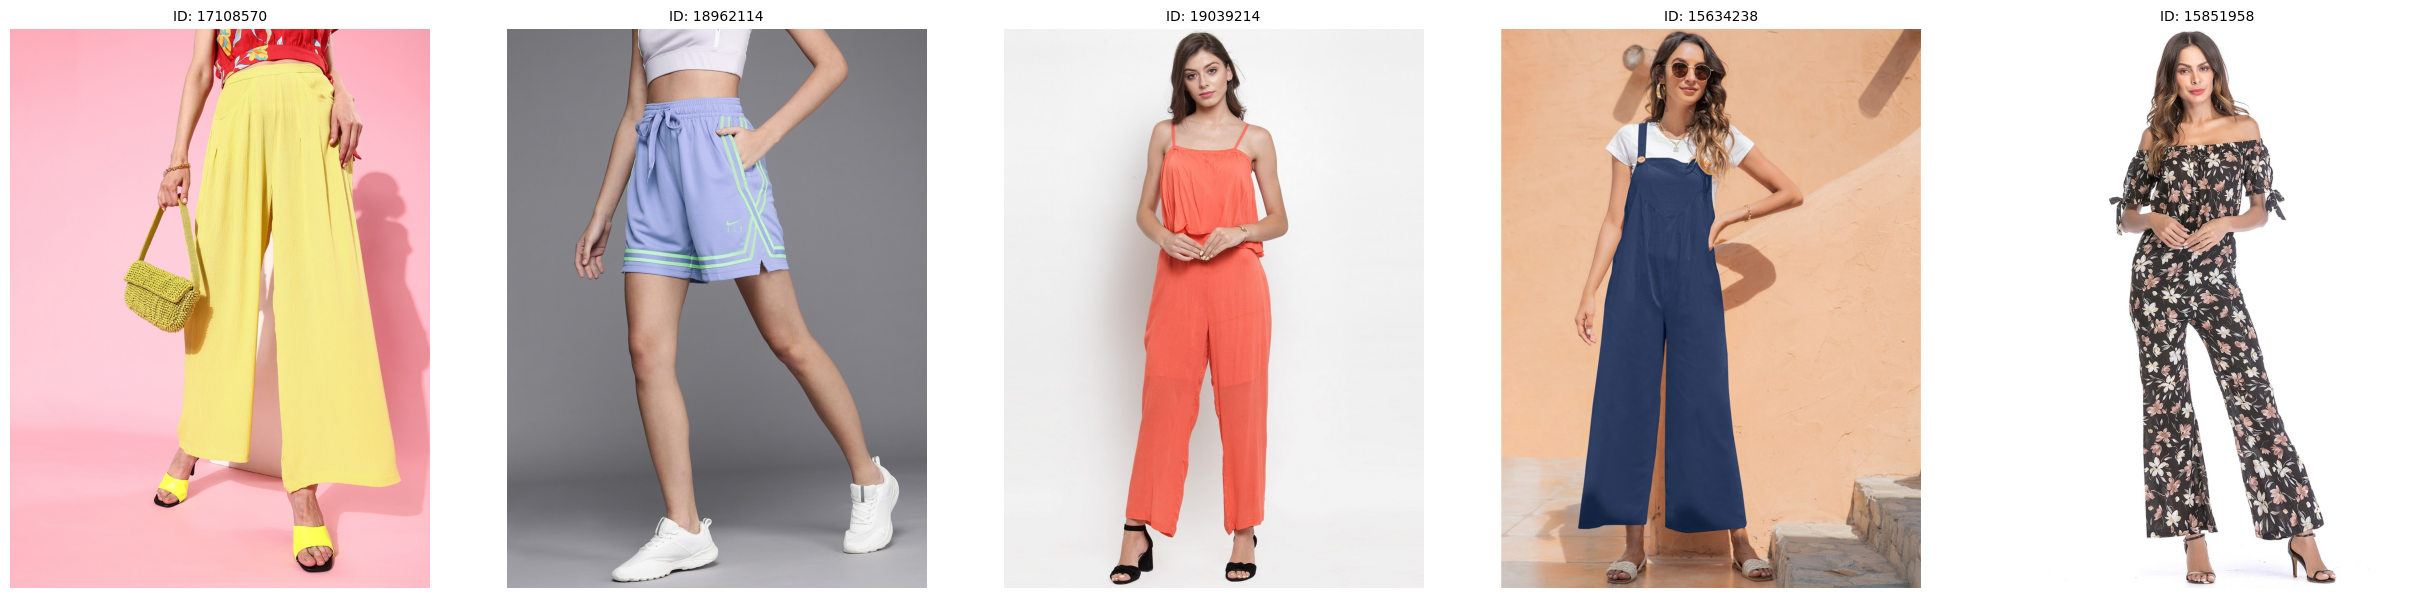

In [69]:
display_top_results_with_images(results_df, images_folder_path, top_k=3)
